<h1>This notebook is an exploration of the structure of the forcing files used for MOHID<h1>
    <ol>
        <li>
            <a href="#winds">Winds</a>
        </li>
        <li>
            <a href="#currents">Currents</a>
        </li>
    </ol>

In [2]:
import numpy
import tables
import xarray

<div id='winds'><a name='Winds'></a><h2>Winds</h2></div>

In [6]:
h5wind = tables.open_file('/ocean/abhudia/MEOPAR/analysis-ashutosh/temp/st_georgia_wind.hdf5')
for group in h5wind.walk_groups():
    print(group)

/ (RootGroup) ''
/Results (Group) ''
/Time (Group) ''
/Results/wind velocity X (Group) ''
/Results/wind velocity Y (Group) ''


<div id='currents'><a name='Currents'></a><h2>Currents</h2></div>

In [7]:
h5current = tables.open_file('/ocean/abhudia/MEOPAR/analysis-ashutosh/temp/St_georgia.hdf5')
for group in h5current.walk_groups():
    print(group)

/ (RootGroup) ''
/Results (Group) ''
/Time (Group) ''
/Results/velocity U (Group) ''
/Results/velocity V (Group) ''
/Results/water level (Group) ''


In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

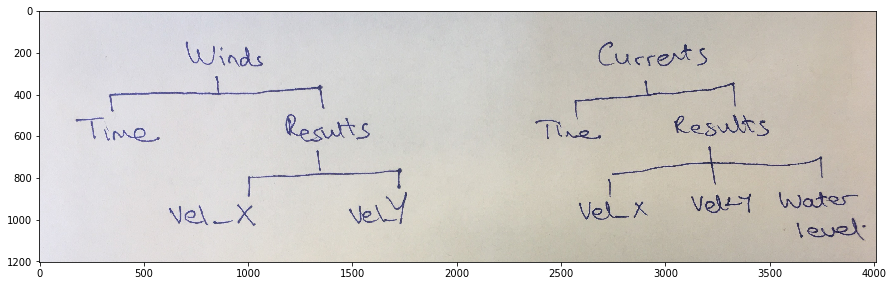

In [18]:
fig = plt.figure(figsize = (15,10))
plt.imshow(mpimg.imread('/home/abhudia/Pictures/image1.jpeg'))